In [121]:
import torch
from torch import nn
import numpy as np
from torch.optim import SGD, Adam
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [122]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [123]:
BATCH_SIZE = 32
LATENT_SIZE = 64

In [124]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [125]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()

    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
    self.batchnorm = nn.BatchNorm2d(out_channels)
    #self.pooling = nn.MaxPool2d((2, 2))
  
    self.layers = [self.conv, self.batchnorm]

  def forward(self, x):
    #logits = x
    #for layer in self.layers:
    #  logits = layer(logits)
    return self.batchnorm(self.conv(x))
  
class DeconvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()

    self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size)
    self.batchnorm = nn.BatchNorm2d(out_channels)

    #self.layers = [self.deconv, self.batchnorm]

  def forward(self, x):
    logits = x
    for layer in self.layers:
      logits = layer(logits)
    return logits

In [126]:
class Encoder(nn.Module):
    input_channels = 1
    conv_filters = (64, 32)
    flatten_out = 32*24*24
    dense_sizes = (LATENT_SIZE,)
    
    def __init__(self):
        super().__init__()

        self.conv1 = ConvBlock(self.input_channels, self.conv_filters[0], (3, 3))
        self.conv2 = ConvBlock(self.conv_filters[0], self.conv_filters[1], (3, 3))
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(self.flatten_out, self.dense_sizes[0]);

        self.seq = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            self.conv2,
            nn.ReLU(),
            self.flatten,
            self.dense1,
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.seq(x)

In [127]:
class Decoder(nn.Module):
    input_shape = LATENT_SIZE
    reshape_in = LATENT_SIZE*22*22
    conv_filters = (64, 32, 1)
    dense_sizes = (64,)
    
    def __init__(self):
        super().__init__()
        
        self.dense1 = nn.Linear(self.input_shape, self.reshape_in)
        self.reshape = nn.Unflatten(1, (LATENT_SIZE, 22, 22))
        self.deconv1 = nn.ConvTranspose2d(LATENT_SIZE, self.conv_filters[0], (3, 3))
        self.deconv2 = nn.ConvTranspose2d(self.conv_filters[0], self.conv_filters[1], (3, 3))
        self.deconv3 = nn.ConvTranspose2d(self.conv_filters[1], self.conv_filters[2], (3, 3))

        self.seq = nn.Sequential(
            self.dense1,
            nn.ReLU(),
            #nn.BatchNorm1d(self.reshape_in),
            self.reshape,
            self.deconv1,
            nn.BatchNorm2d(self.conv_filters[0]),
            nn.ReLU(),
            self.deconv2,
            nn.BatchNorm2d(self.conv_filters[1]),
            nn.ReLU(),
            self.deconv3,
            nn.BatchNorm2d(self.conv_filters[2]),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.seq(x)

In [128]:
class Autoencoder(nn.Module):
    input_shape = (1, 28, 28);
    
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        encoder_out = self.encoder(x)
        return self.decoder(encoder_out);

In [129]:
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

#mnist_data = MNIST("KMNIST/raw/train-images-idx3-ubyte", transform=ToTensor(), download=True)
mnist_data = FashionMNIST("Fashion MNIST/raw/train-images-idx3-ubyte", transform=ToTensor(), download=True)
loader = DataLoader(mnist_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [130]:
encoder = Encoder()
encoder = encoder.to(device)

In [131]:
decoder = Decoder()
decoder = decoder.to(device)

In [132]:
autoencoder = Autoencoder(encoder, decoder)
autoencoder = autoencoder.to(device)
#autoencoder.cuda()

#summary(autoencoder, (1, 28, 28))
summary(encoder, (1, 28, 28))
summary(decoder, (LATENT_SIZE,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
            Conv2d-2           [-1, 64, 26, 26]             640
       BatchNorm2d-3           [-1, 64, 26, 26]             128
       BatchNorm2d-4           [-1, 64, 26, 26]             128
         ConvBlock-5           [-1, 64, 26, 26]               0
         ConvBlock-6           [-1, 64, 26, 26]               0
              ReLU-7           [-1, 64, 26, 26]               0
            Conv2d-8           [-1, 32, 24, 24]          18,464
            Conv2d-9           [-1, 32, 24, 24]          18,464
      BatchNorm2d-10           [-1, 32, 24, 24]              64
      BatchNorm2d-11           [-1, 32, 24, 24]              64
        ConvBlock-12           [-1, 32, 24, 24]               0
        ConvBlock-13           [-1, 32, 24, 24]               0
             ReLU-14           [-1, 32,

In [133]:
optimizer = Adam(autoencoder.parameters(), lr=0.01)
loss_fn = nn.MSELoss();

def train(epochs):
    for i in range(epochs):
        autoencoder.train()
        for batch_index, (data, _) in enumerate(loader):
            #to_device(data, device)
            data = data.to(device)
            data.cuda()
            #print(data.is_cuda)

            optimizer.zero_grad()
            #print("here")
            output = autoencoder(data)

            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()

            if(batch_index % 100 == 0):
                print("Batch index: {}, loss: {}".format(batch_index, loss))

In [134]:
train(10)

Batch index: 0, loss: 0.2541266679763794
Batch index: 100, loss: 0.03783002495765686
Batch index: 200, loss: 0.028711950406432152
Batch index: 300, loss: 0.023531923070549965
Batch index: 400, loss: 0.020371098071336746
Batch index: 500, loss: 0.01920069381594658
Batch index: 600, loss: 0.013760770671069622
Batch index: 700, loss: 0.01476229541003704
Batch index: 800, loss: 0.012579288333654404
Batch index: 900, loss: 0.01122279092669487
Batch index: 1000, loss: 0.016957370564341545
Batch index: 1100, loss: 0.0147000877186656
Batch index: 1200, loss: 0.011588438414037228
Batch index: 1300, loss: 0.01182479690760374
Batch index: 1400, loss: 0.010671581141650677
Batch index: 1500, loss: 0.010383741930127144
Batch index: 1600, loss: 0.0112049151211977
Batch index: 1700, loss: 0.013852282427251339
Batch index: 1800, loss: 0.009766973555088043
Batch index: 0, loss: 0.010794867761433125
Batch index: 100, loss: 0.011692682281136513
Batch index: 200, loss: 0.010700984857976437
Batch index: 300

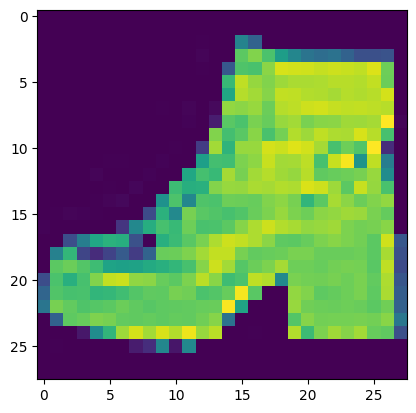

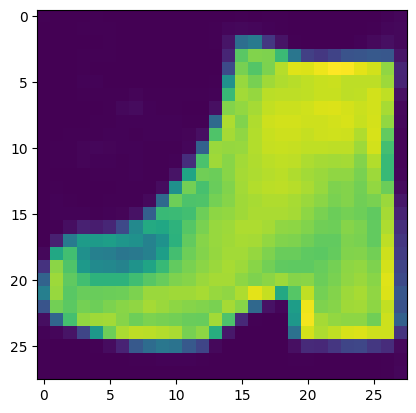

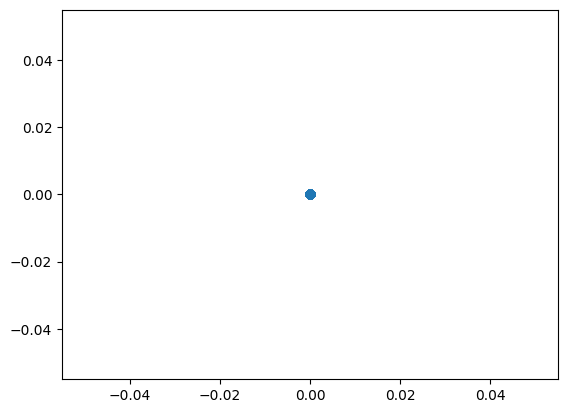

In [135]:
#display original image + reconstructed image

test_loader = DataLoader(mnist_data, batch_size=256, shuffle=True, num_workers=2)

for image, label in test_loader:
    image = image.to(device)
    
    encoder_out = encoder(image)
    all_out = decoder(encoder_out)
    all_out1 = autoencoder(image)
    
    image = image.cpu()
    plt.imshow(image.detach().numpy()[0][0])
    plt.show()

    all_out1 = all_out1.cpu()
    plt.imshow(all_out1.detach().numpy()[0][0])
    plt.show()
    
    x, y = [], []
    for out in encoder_out:
        x.append(out[0].item())
        y.append(out[1].item())
    plt.scatter(x, y)
    break

In [136]:
from sklearn.cluster import KMeans

#clustering to see how the embeddings relate to the actual class

for image, label in test_loader:
    image = image.to(device)

    out = encoder(image)
    
    out = out.cpu()
    print(out)
    kmeans = KMeans(n_clusters=10).fit(out.detach().numpy())

    print(label.detach().numpy())
    print(kmeans.labels_)
    
    break

tensor([[   0.0000,    0.0000, 1144.7212,  ...,  726.1646,  292.1100,
          400.9059],
        [   0.0000,    0.0000, 1496.9425,  ...,  272.3490,  683.0184,
          433.8019],
        [   0.0000,    0.0000,  211.5765,  ...,  139.4020,  653.5844,
           40.3010],
        ...,
        [   0.0000,    0.0000, 1067.2748,  ...,  545.7753, 1273.3408,
          348.2637],
        [   0.0000,    0.0000,   98.9459,  ...,  342.3492,  577.3687,
          292.8505],
        [   0.0000,    0.0000, 1372.2373,  ...,   68.1335,  398.5390,
          522.5929]], grad_fn=<ToCopyBackward0>)
[3 6 2 0 3 7 0 5 6 8 2 6 3 9 7 0 4 3 5 8 7 2 3 3 4 0 4 8 1 2 4 0 2 3 9 4 5
 2 5 2 2 3 2 9 7 0 9 1 1 4 7 4 3 5 6 2 8 8 5 8 4 0 5 5 6 2 9 3 4 5 6 1 1 1
 6 7 3 6 3 1 1 8 3 3 5 1 6 8 2 6 2 1 1 9 7 5 6 7 3 4 8 5 3 0 0 3 7 6 9 9 7
 5 8 9 9 4 6 2 4 4 1 6 7 9 2 4 6 7 3 2 1 3 3 1 6 6 7 7 9 7 5 9 0 3 4 4 2 3
 6 8 2 8 6 1 3 5 8 5 2 7 9 0 9 7 8 8 4 6 3 8 5 1 7 0 3 6 8 3 1 6 9 1 8 8 1
 0 2 9 6 7 4 4 0 6 9 0 1 2 6 8 7 5 9 6

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


torch.Size([256, 1, 28, 28])
torch.Size([1, 28, 28])


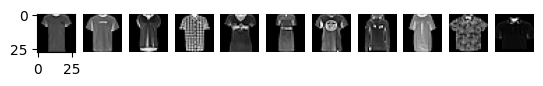

In [137]:
#find 

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors = 25)
orig_outs = []
orig_images = []

for image, label in test_loader:
  image = image.to(device)

  out = encoder(image).cpu()

  out = out.detach().numpy()
  orig_outs = out
  orig_images = image.cpu()
  neigh.fit(out)
  break

print(orig_images.shape)
print(orig_images[0].shape)

for image, label in test_loader:
  image = image.to(device)

  figure = plt.figure()

  out = encoder(image).cpu()
  out = out.detach().numpy()
  nearest = neigh.kneighbors([out[0]], return_distance=False)
  
  figure.add_subplot(1, 11, 1)

  image = image.cpu()
  plt.imshow(image[0][0])

  for i in range(11):
    figure.add_subplot(1, 11, i+1)

    nearest_tensor = torch.tensor([orig_outs[nearest[0][i]]]).to(device)

    res1 = decoder(nearest_tensor).cpu().detach().numpy()[0][0]
    res2 = orig_images[nearest[0][i]].detach().numpy()[0]

    plt.imshow(res2, cmap="Greys_r")
    plt.axis("off")
  plt.show()
  break

(64,)


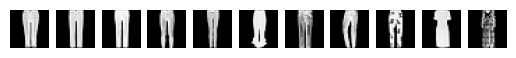

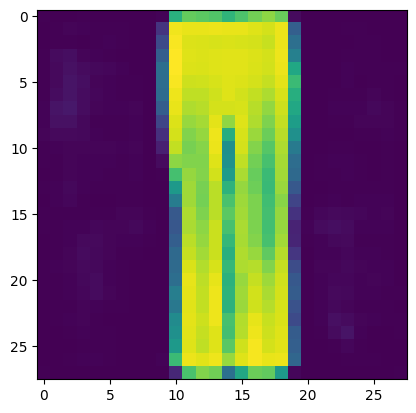

In [138]:
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from torchvision.transforms.functional import resize

figure = plt.figure()

range_min, range_max = np.ones((LATENT_SIZE,))*10000, np.zeros((LATENT_SIZE,))
distributions = []
distributions_mixture = []
mixture_model = GaussianMixture(n_components=10)

for image, labels in test_loader:
  image = image.to(device)

  out = encoder(image).cpu()
  out = out.detach().numpy()
  for i in range(BATCH_SIZE):
    for j in range(LATENT_SIZE):
      range_min[j] = min(range_min[j], out[i][j])
      range_max[j] = max(range_max[j], out[i][j])
  
  for i in range(LATENT_SIZE):
    x = []
    for j in range(BATCH_SIZE):
      x.append(out[j][i])
    mean, std = norm.fit(x)
    distributions.append((mean, std))
  mixture_model = mixture_model.fit(out)
  break

fake_embedding = mixture_model.sample()[0][0]
print(fake_embedding.shape)

nearest = neigh.kneighbors([fake_embedding], return_distance=False)[0]

for i in range(11):
  figure.add_subplot(1, 11, i+1)

  res = orig_images[nearest[i]]

  plt.imshow(res.detach().numpy()[0], cmap="Greys_r")
  plt.axis("off")
plt.show()

fake_embedding.resize((1,LATENT_SIZE))
fake_embedding = torch.tensor(fake_embedding).to(device)

fake_img = decoder(fake_embedding.float()).cpu()
plt.imshow(fake_img.detach().numpy()[0][0])